# Network Analysis

This notebook provide analysis metrics on 3 complex networks: 

- [Amazon Co-purchase](http://snap.stanford.edu/data/com-Amazon.html)
- [Wikipedia Admin Election](http://snap.stanford.edu/data/wiki-Elec.html)

The following metrics are obtained: 

- Degree
- Distance 
- Closeness
- Betweenness

## Imports

In [51]:
import networkx as nx
from powerlaw import ccdf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

### Initializing Variables

In [143]:
dict_metrics = {}
dict_plots = {}
df_output = pd.DataFrame(columns=["dataset_tag", "metric", "max", "min", "mean", "median", "std"])

## Processing Datafiles

For each dataset, a source file is processed in order to create an adjacency-list output file.

### Amazon Co-purchase

In [144]:
dataset_tag, dataset_file = "amazon_copurchase", "./com-amazon.ungraph.txt"
dict_metrics[dataset_tag] = dict()
dict_plots[dataset_tag] = dict()
df = pd.read_csv(dataset_file, header=None, skiprows=4, sep='\t')
df.columns = ["from", "to"]
df.to_csv("./" + dataset_tag + "_edgelist.txt", sep='\t', index=False, header=None)
df.tail()

,from,to
925867,548343,548378
925868,548354,548356
925869,548368,548454
925870,548391,548411
925871,548411,548458


### Movie Lens 1M

In [116]:
dataset_tag, dataset_file = "ml1m", "./ratings.dat"
dict_metrics[dataset_tag] = dict()
dict_plots[dataset_tag] = dict()
df = pd.read_csv(dataset_file, header=None, sep=r'::', engine="python")
df.columns = ["from", "to", "rating", "timestamp"]
df['from'] = df['from'].apply(lambda x: 'user_' + str(x))
df['to'] = df['to'].apply(lambda x: 'item_' + str(x))
df.drop(["timestamp"], axis=1, inplace=True)
df.to_csv("./" + dataset_tag + "_edgelist.txt", sep='\t', index=False, header=None)
df.head()

,from,to,rating
0,user_1,item_1193,5
1,user_1,item_661,3
2,user_1,item_914,3
3,user_1,item_3408,4
4,user_1,item_2355,5


## Creating Network

In [145]:
if dataset_tag == "ml1m":
    G = nx.DiGraph()
    G.add_weighted_edges_from(df[["from", "to", "rating"]].values)
else: 
    G = nx.read_edgelist("./" + dataset_tag + "_edgelist.txt", delimiter='\t', nodetype=str, data=(('weight',float),))
print (list(G.edges)[:3])
print ("Number of edges: ", G.number_of_edges())
print ("Number of nodes: ", G.number_of_nodes())
print ("Transitivity: ", nx.transitivity(G))
if not G.is_directed():
    print ("Is connected: ", nx.is_connected(G))
    print ("Number of connected components: ", nx.number_connected_components(G))
else:
    print ("Is strongly connected: ", nx.is_strongly_connected(G))
    print ("Number of strongly connected components: ", nx.number_strongly_connected_components(G))

[('1', '88160'), ('1', '118052'), ('1', '161555')]
Number of edges:  925872
Number of nodes:  334863
Transitivity:  0.20522444916452579
Is connected:  True
Number of connected components:  1


In [34]:
# nx.diameter(G)

## Getting Stats


### Degrees

In [146]:
df_stats = pd.DataFrame(nx.degree(G))
df_stats.columns = ['node', 'degree']
df_stats['degree_centrality'] = nx.degree_centrality(G).values()
dict_metrics[dataset_tag]["degree"] = np.array(df_stats["degree"])
df_stats.head()

,node,degree,degree_centrality
0,1,8,0.000024
1,88160,7,0.000021
2,118052,18,0.000054
3,161555,31,0.000093
4,244916,26,0.000078


In [147]:
df_output.loc[df_output.shape[0]] = [dataset_tag, 
     "degree", df_stats["degree"].max(), df_stats["degree"].min(), 
     '{:.02f}'.format(df_stats["degree"].mean()), 
     '{:.02f}'.format(df_stats["degree"].median()),
     '{:.02f}'.format(df_stats["degree"].std())]
df_output

,dataset_tag,metric,max,min,mean,median,std
0,amazon_copurchase,degree,549,1,5.53,4.00,5.76


In [148]:
if G.is_directed():
    df_output.loc[df_output.shape[0]] = [dataset_tag, "out-degree", 
         df_stats[df_stats.node.str.contains("user")]["degree"].max(), 
         df_stats[df_stats.node.str.contains("user")]["degree"].min(), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("user")]["degree"].mean()), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("user")]["degree"].median()),
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("user")]["degree"].std())]

    df_output.loc[df_output.shape[0]] = [dataset_tag, "in-degree", 
         df_stats[df_stats.node.str.contains("item")]["degree"].max(), 
         df_stats[df_stats.node.str.contains("item")]["degree"].min(), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("item")]["degree"].mean()), 
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("item")]["degree"].median()),
         '{:.02f}'.format(df_stats[df_stats.node.str.contains("item")]["degree"].std())]
df_output   

,dataset_tag,metric,max,min,mean,median,std
0,amazon_copurchase,degree,549,1,5.53,4.00,5.76


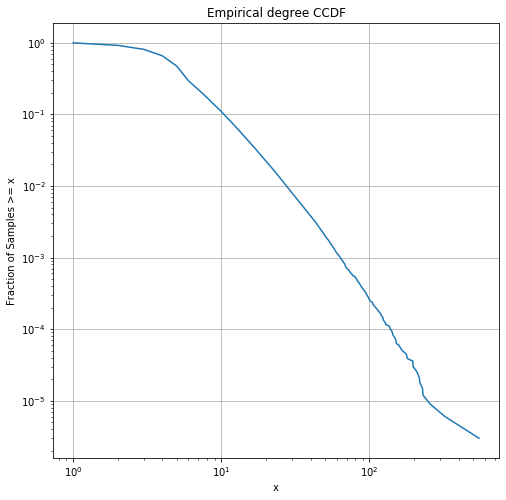

In [149]:
def plot_ccdf(samples, name=''):
    x, y = ccdf(samples)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.set_title("Empirical " + name + " CCDF")
    ax.plot(x, y)
    ax.set_xscale("log"), ax.set_yscale("log")
    ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
    ax.grid(True)
    return fig, ax 

fig, ax = plot_ccdf(df_stats["degree"], "degree")
dict_plots[dataset_tag]["degree"] = dict()
dict_plots[dataset_tag]["degree"]["fig"], dict_plots[dataset_tag]["degree"]["ax"] = fig, ax
fig.savefig("./images/{}_empirical_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

In [150]:
if dataset_tag == "ml1m":    
    fig, ax = plot_ccdf(df_stats[df_stats.node.str.contains("user")]["degree"], "in-degrees")
    dict_plots[dataset_tag]["out-degree"] = dict()
    dict_plots[dataset_tag]["out-degree"]["fig"], dict_plots[dataset_tag]["out-degree"]["ax"] = fig, ax
    fig.savefig("./images/{}_empirical_out_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")
    
    fig, ax = plot_ccdf(df_stats[df_stats.node.str.contains("item")]["degree"], "in-degrees")    
    dict_plots[dataset_tag]["in-degree"] = dict()
    dict_plots[dataset_tag]["in-degree"]["fig"], dict_plots[dataset_tag]["in-degree"]["ax"] = fig, ax
    fig.savefig("./images/{}_empirical_in_degrees_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")
    

## Sample-based Metrics

In [157]:
%%time
n_trial_nodes = 100
arr_dist = arr_close = arr_clust = np.array([])
for node in np.random.choice(df_stats["node"].unique(), size=n_trial_nodes):
    node_dist = np.array(list(nx.shortest_path_length(G, node).values())[1:])
    node_close = nx.closeness_centrality(G, node)
    arr_dist = np.append(arr_dist, node_dist)
    arr_close = np.append(arr_close, node_close)
    arr_clust = np.append(arr_clust, nx.clustering(G, node))
    
dict_metrics[dataset_tag]["distance"] = arr_dist
dict_metrics[dataset_tag]["closeness"] = arr_close
dict_metrics[dataset_tag]["clustering"] = arr_clust

Wall time: 5min 54s


### Distance

In [158]:
df_output.loc[df_output.shape[0]] = [dataset_tag, "distance", 
     arr_dist.max(), arr_dist.min(), 
     '{:.02f}'.format(arr_dist.mean()), 
     '{:.02f}'.format(np.median(arr_dist)),
     '{:.02f}'.format(arr_dist.std())]
df_output

,dataset_tag,metric,max,min,mean,median,std
0,amazon_copurchase,degree,549,1,5.53,4.00,5.76
1,amazon_copurchase,distance,35,1,12.16,12.00,2.70
2,amazon_copurchase,closeness,0.0963342,0.0712237,0.08,0.08,0.01
3,amazon_copurchase,distance,41,1,12.06,12.00,3.14


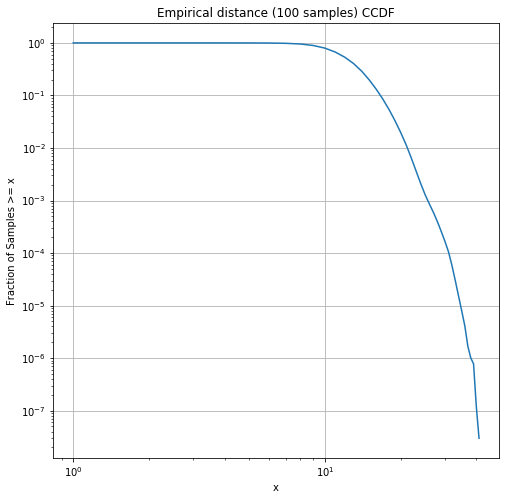

In [159]:
fig, ax = plot_ccdf(arr_dist, name="distance ({} samples)".format(n_trial_nodes))
dict_plots[dataset_tag]["distance"] = dict()
dict_plots[dataset_tag]["distance"]["fig"], dict_plots[dataset_tag]["distance"]["ax"] = fig, ax
fig.savefig("./images/{}_empirical_distances_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

### Closeness

In [160]:
df_output.loc[df_output.shape[0]] = [dataset_tag, "closeness", 
     arr_close.max(), arr_close.min(), 
     '{:.02f}'.format(arr_close.mean()), 
     '{:.02f}'.format(np.median(arr_close)),
     '{:.02f}'.format(arr_close.std())]
df_output

,dataset_tag,metric,max,min,mean,median,std
0,amazon_copurchase,degree,549,1,5.53,4.00,5.76
1,amazon_copurchase,distance,35,1,12.16,12.00,2.70
2,amazon_copurchase,closeness,0.0963342,0.0712237,0.08,0.08,0.01
3,amazon_copurchase,distance,41,1,12.06,12.00,3.14
4,amazon_copurchase,closeness,0.115648,0.0497709,0.08,0.09,0.01


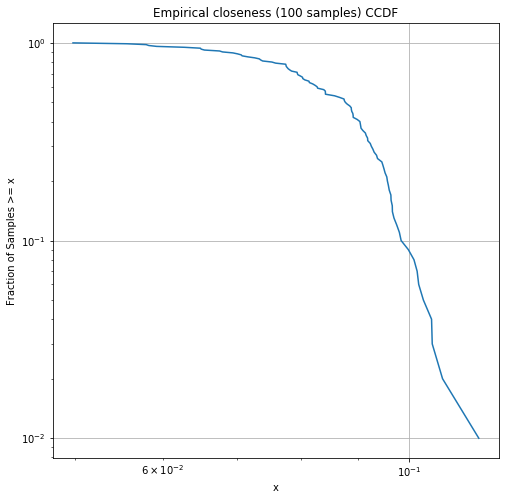

In [161]:
fig, ax = plot_ccdf(arr_close, name="closeness ({} samples)".format(n_trial_nodes))
dict_plots[dataset_tag]["closeness"] = dict()
dict_plots[dataset_tag]["closeness"]["fig"], dict_plots[dataset_tag]["closeness"]["ax"] = fig, ax
fig.savefig("./images/{}_empirical_closeness_ccdf.jpeg".format(dataset_tag), bbox_inches="tight")

In [32]:
df_stats.describe()

,node,degree,degree_centrality
count,334863.000000,334863.000000,334863.000000
mean,276768.565727,5.529855,0.000017
std,159927.553896,5.761639,0.000017
min,1.000000,1.000000,0.000003
25%,138028.000000,3.000000,0.000009
50%,276405.000000,4.000000,0.000012
75%,415626.500000,6.000000,0.000018
max,548551.000000,549.000000,0.001639


## Plotting All Datasets

_______________

In [179]:
G=nx.DiGraph()

G.add_edge('u1','i1',weight=0.6)
G.add_edge('u1','i2',weight=0.2)
G.add_edge('u2','i1',weight=0.1)

KeyError: 'a'

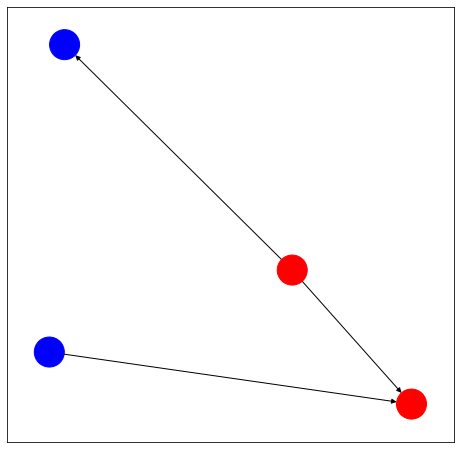

In [180]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
nx.draw(G,pos=nx.spring_layout(G), 
        label="uhu", 
        node_size=900, 
        node_color=['r', 'r', 'b', 'b'],
        labels={'u1': 'u1', 'u2': 'u2', 'i1': 'i1', 'd': 4},
        ax=ax)
plt.show()